# HW 06

Charlie Perez (cwp5xyj)

### Setting up the workspace

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly_express as px

import configparser
config = configparser.ConfigParser()
config.read("../../../env.ini")
data_home = config['DEFAULT']['data_home'] 
output_dir = config['DEFAULT']['output_dir']
data_prefix = 'austen-melville'

In [2]:
OHCO = ['book_id', 'chap_id', 'para_num', 'sent_num', 'token_num']

LIB = pd.read_csv(f"{output_dir}/{data_prefix}-LIB.csv").set_index('book_id')
TOKEN = pd.read_csv(f'{output_dir}/{data_prefix}-CORPUS.csv').set_index(OHCO).dropna()

In [17]:
# remove Melville works
melvilles = [i for i in list(LIB.index) if LIB.loc[i, 'author'] == 'MELVILLE, HERMAN']
LIB = LIB.drop(melvilles)
TOKEN = TOKEN.drop(melvilles)

In [19]:
TOKEN.head()

pos_tuple  pos  \
book_id chap_id para_num sent_num token_num                             
105     1       1        0        0               ('Sir', 'NNP')  NNP   
                                  1            ('Walter', 'NNP')  NNP   
                                  2           ('Elliot,', 'NNP')  NNP   
                                  3                 ('of', 'IN')   IN   
                                  4          ('Kellynch', 'NNP')  NNP   

                                            token_str  term_str pos_group  
book_id chap_id para_num sent_num token_num                                
105     1       1        0        0               Sir       sir        NN  
                                  1            Walter    walter        NN  
                                  2           Elliot,    elliot        NN  
                                  3                of        of        IN  
                                  4          Kellynch  kellynch        NN

In [22]:
# unfortunately, because I did not generate a fresh VOCAB table, I need to write this from scratch
import nltk

VOCAB = TOKEN.term_str.value_counts().to_frame('n').sort_index()
VOCAB.index.name = 'term_str'
VOCAB['n_chars'] = VOCAB.index.str.len()
VOCAB['p'] = VOCAB.n / VOCAB.n.sum()
VOCAB['i'] = -np.log2(VOCAB.p)

VOCAB['max_pos'] = TOKEN[['term_str','pos']].value_counts().unstack(fill_value=0).idxmax(1)
VOCAB['max_pos_group'] = TOKEN[['term_str','pos_group']].value_counts().unstack(fill_value=0).idxmax(1)

VOCAB['n_pos_group'] = TOKEN[['term_str','pos_group']].value_counts().unstack().count(1)
VOCAB['cat_pos_group'] = TOKEN[['term_str','pos_group']].value_counts().to_frame('n').reset_index()\
    .groupby('term_str').pos_group.apply(lambda x: set(x))

VOCAB['n_pos'] = TOKEN[['term_str','pos']].value_counts().unstack().count(1)
VOCAB['cat_pos'] = TOKEN[['term_str','pos']].value_counts().to_frame('n').reset_index()\
    .groupby('term_str').pos.apply(lambda x: set(x))

sw = pd.DataFrame(nltk.corpus.stopwords.words('english'), columns=['term_str'])
sw = sw.reset_index().set_index('term_str')
sw.columns = ['dummy']
sw.dummy = 1

VOCAB['stop'] = VOCAB.index.map(sw.dummy)
VOCAB['stop'] = VOCAB['stop'].fillna(0).astype('int')

from nltk.stem.porter import PorterStemmer
stemmer1 = PorterStemmer()
VOCAB['stem_porter'] = VOCAB.apply(lambda x: stemmer1.stem(x.name), 1)

from nltk.stem.snowball import SnowballStemmer
stemmer2 = SnowballStemmer("english")
VOCAB['stem_snowball'] = VOCAB.apply(lambda x: stemmer2.stem(x.name), 1)

from nltk.stem.lancaster import LancasterStemmer
stemmer3 = LancasterStemmer()
VOCAB['stem_lancaster'] = VOCAB.apply(lambda x: stemmer3.stem(x.name), 1)

In [23]:
VOCAB.sample(10)

,n,n_chars,p,i,max_pos,max_pos_group,n_pos_group,cat_pos_group,n_pos,cat_pos,stop,stem_porter,stem_snowball,stem_lancaster
term_str,,,,,,,,,,,,,,
relish,5,6,0.000006,17.252577,NN,NN,2,"{NN, VB}",2,"{NN, VB}",0,relish,relish,rel
affirm,4,6,0.000005,17.574505,VB,VB,1,{VB},1,{VB},0,affirm,affirm,affirm
satirical,4,9,0.000005,17.574505,JJ,JJ,2,"{VB, JJ}",2,"{VB, JJ}",0,satir,satir,satir
blanks,1,6,0.000001,19.574505,NNS,NN,1,{NN},1,{NNS},0,blank,blank,blank
jolt,1,4,0.000001,19.574505,NN,NN,1,{NN},1,{NN},0,jolt,jolt,jolt
creditor,1,8,0.000001,19.574505,NN,NN,1,{NN},1,{NN},0,creditor,creditor,credit
gloried,5,7,0.000006,17.252577,VBN,VB,1,{VB},2,"{VBN, VBD}",0,glori,glori,glory
independant,4,11,0.000005,17.574505,NN,NN,2,"{NN, JJ}",2,"{NN, JJ}",0,independ,independ,independ
mr,3119,2,0.003995,7.967637,NNP,NN,6,"{VB, PO, PR, JJ, NN, RB}",8,"{POS, VB, JJ, NNP, NNS, NN, PRP, RB}",0,mr,mr,mr


| book_id | year | title                                     |
|---------|------|-------------------------------------------|
| 158     | 1815 | Emma                                      |
| 946     | 1794 | Lady Susan                                |
| 1212    | 1790 | Love And Freindship And Other Early Works |
| 141     | 1814 | Mansfield Park                            |
| 121     | 1803 | Northanger Abbey                          |
| 105     | 1818 | Persuasion                                |
| 1342    | 1813 | Pride and Prejudice                       |
| 161     | 1811 | Sense and Sensibility                     |

In [26]:
match_dict = {158:1815, 946:1794, 1212:1790, 141:1814, 121:1803, 105:1818, 1342:1813, 161:1811}
LIB['year'] = LIB.index.map(match_dict)
LIB

,source_file_path,author,title,chap_regex,book_len,n_chaps,year
book_id,,,,,,,
105,/home/cwp5xyj/Documents/MSDS/DS5001/data/auste...,"AUSTEN, JANE",PERSUASION,^Chapter\s+\d+$,83624,24,1818
121,/home/cwp5xyj/Documents/MSDS/DS5001/data/auste...,"AUSTEN, JANE",NORTHANGER ABBEY,^CHAPTER\s+\d+$,77601,31,1803
141,/home/cwp5xyj/Documents/MSDS/DS5001/data/auste...,"AUSTEN, JANE",MANSFIELD PARK,^CHAPTER\s+[IVXLCM]+$,160378,48,1814
158,/home/cwp5xyj/Documents/MSDS/DS5001/data/auste...,"AUSTEN, JANE",EMMA,^\s*CHAPTER\s+[IVXLCM]+\s*$,160926,55,1815
161,/home/cwp5xyj/Documents/MSDS/DS5001/data/auste...,"AUSTEN, JANE",SENSE AND SENSIBILITY,^CHAPTER\s+\d+$,119873,50,1811
946,/home/cwp5xyj/Documents/MSDS/DS5001/data/auste...,"AUSTEN, JANE",LADY SUSAN,^\s*[IVXLCM]+\s*$,23116,41,1794
1212,/home/cwp5xyj/Documents/MSDS/DS5001/data/auste...,"AUSTEN, JANE",LOVE AND FREINDSHIP SIC,^\s*LETTER .* to .*$,33265,24,1790
1342,/home/cwp5xyj/Documents/MSDS/DS5001/data/auste...,"AUSTEN, JANE",PRIDE AND PREJUDICE,^Chapter\s+\d+$,122126,61,1813


In [27]:
# looks fine
# pasting BOW and TFIDF functions from last week

def bag_of_words(tokens, bag):
    
    # we're just gonna instantiate stuff within the function just in case
    OHCO = ['book_id', 'chap_id', 'para_num', 'sent_num', 'token_num']
    bags = dict(
        SENTS = OHCO[:4],
        PARAS = OHCO[:3],
        CHAPS = OHCO[:2],
        BOOKS = OHCO[:1]
    )
    
    # bit of error handling (mostly just for practice)
    bag = bag.upper()
    if bag not in bags:
        raise ValueError(F'Invalid input: Value must be one of {list(bags.keys())}')
        
        
    BOW = tokens.groupby(bags[bag]+['term_str']).term_str.count().to_frame('n')
    
    return BOW

def TFIDF_from_BOW(BOW, tf_method):
    # 'parameters' that we aren't gonna make variable for this function
    tf_norm_k = .5
    gradient_cmap = 'YlGnBu'
    
    # first make DTCM and calculate N
    DTCM = BOW.n.unstack(fill_value=0)
    N = DTCM.shape[0]
    
    tf_methods = {
        'sum': (DTCM.T / DTCM.T.sum()).T,
        'max': (DTCM.T / DTCM.T.max()).T,
        'log': (np.log2(1 + DTCM.T)).T,
        'raw':  DTCM,
        'double_norm': (DTCM.T / DTCM.T.max()).T,
        'binary': DTCM.T.astype('bool').astype('int').T
    }
    
    # just for fun
    tf_method = tf_method.lower()
    if tf_method not in tf_methods:
        raise ValueError(F'Invalid input: Value must be one of {list(tf_methods.keys())}')
    
    TF = tf_methods[tf_method]
    DF = DTCM.astype('bool').sum()
    IDF = np.log2(N / DF) # not variable according to assignment rules, but could easily be
    TFIDF = TF * IDF
    DFIDF = DF * np.log2(len(TFIDF)/DF) # adding DFIDF
    

    return TFIDF, DFIDF

In [31]:
BOW = bag_of_words(TOKEN, 'chaps')
BOW.sample(10)

,,,n
book_id,chap_id,term_str,
1342,46,f,5
121,12,answered,1
161,10,confinement,1
1342,29,own,2
946,24,now,6
141,36,thoughts,2
121,24,journal,1
158,38,speaking,2
121,11,wet,3


In [32]:
TFIDF, DFIDF = TFIDF_from_BOW(BOW, 'max')

In [37]:
TFIDF.shape

(334, 14745)

In [38]:
DFIDF.shape

(14745,)

In [55]:
# first, filter DFIDF to remove terms not in the allowed list
allowed_pos = ['NN', 'NNS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS']
allowed_terms = VOCAB[VOCAB['max_pos'].isin(allowed_pos)]
DFIDF_filtered = DFIDF[DFIDF.index.isin(allowed_terms.index)]

In [59]:
# then, filter top 1k
top_1k = DFIDF_filtered.sort_values(ascending=False).head(1000)

In [60]:
top_1k.head()

term_str
stay        177.266344
greatest    177.266344
respect     177.266344
forward     177.266344
thinking    177.266344
dtype: float64

In [63]:
TFIDF_filtered = TFIDF[top_1k.index]
TFIDF_filtered.shape

(334, 1000)

In [68]:
# collapse to book level
TFIDF_book = TFIDF_filtered.groupby(OHCO[:1]).mean()
# TFIDF_book

| Distance Measure | Norming | Linkage  |
|------------------|---------|----------|  
| cityblock        | None    | weighted |
| cosine           | None    | ward     |
| euclidean        | L2      | ward     |  
| jaccard          | L0      | weighted | 
| jensenshannon    | L1      | weighted |

In [70]:
from numpy.linalg import norm
from scipy.spatial.distance import pdist
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import plotly_express as px
import seaborn as sns; sns.set()

In [71]:
L0 = TFIDF_book.astype('bool').astype('int') # Binary (Pseudo L)
L1 = TFIDF_book.apply(lambda x: x / x.sum(), 1) # Probabilistic
L2 = TFIDF_book.apply(lambda x: x / norm(x), 1) # Pythagorean, AKA Euclidean

In [72]:
PAIRS = pd.DataFrame(index=pd.MultiIndex.from_product([LIB.index.tolist(), LIB.index.tolist()])).reset_index()

# Keep only unique pairs of different books
PAIRS = PAIRS[PAIRS.level_0 < PAIRS.level_1].set_index(['level_0','level_1'])

# Name index cols
PAIRS.index.names = ['doc_a', 'doc_b']

In [73]:
PAIRS.shape

(28, 0)

In [84]:
PAIRS['cityblock'] = pdist(TFIDF_book, 'cityblock')
PAIRS['cosine'] = pdist(TFIDF_book, 'cosine')
PAIRS['euclidean'] = pdist(L2, 'euclidean')
PAIRS['jaccard'] = pdist(L0, 'jaccard')
PAIRS['js'] = pdist(L1, 'jensenshannon')  

In [82]:
LIB['label'] = LIB.title + ' (' + LIB.year.astype('str') + ')'
LIB['label'] = LIB.label.str.title()
LIB

,source_file_path,author,title,chap_regex,book_len,n_chaps,year,label
book_id,,,,,,,,
105,/home/cwp5xyj/Documents/MSDS/DS5001/data/auste...,"AUSTEN, JANE",PERSUASION,^Chapter\s+\d+$,83624,24,1818,Persuasion (1818)
121,/home/cwp5xyj/Documents/MSDS/DS5001/data/auste...,"AUSTEN, JANE",NORTHANGER ABBEY,^CHAPTER\s+\d+$,77601,31,1803,Northanger Abbey (1803)
141,/home/cwp5xyj/Documents/MSDS/DS5001/data/auste...,"AUSTEN, JANE",MANSFIELD PARK,^CHAPTER\s+[IVXLCM]+$,160378,48,1814,Mansfield Park (1814)
158,/home/cwp5xyj/Documents/MSDS/DS5001/data/auste...,"AUSTEN, JANE",EMMA,^\s*CHAPTER\s+[IVXLCM]+\s*$,160926,55,1815,Emma (1815)
161,/home/cwp5xyj/Documents/MSDS/DS5001/data/auste...,"AUSTEN, JANE",SENSE AND SENSIBILITY,^CHAPTER\s+\d+$,119873,50,1811,Sense And Sensibility (1811)
946,/home/cwp5xyj/Documents/MSDS/DS5001/data/auste...,"AUSTEN, JANE",LADY SUSAN,^\s*[IVXLCM]+\s*$,23116,41,1794,Lady Susan (1794)
1212,/home/cwp5xyj/Documents/MSDS/DS5001/data/auste...,"AUSTEN, JANE",LOVE AND FREINDSHIP SIC,^\s*LETTER .* to .*$,33265,24,1790,Love And Freindship Sic (1790)
1342,/home/cwp5xyj/Documents/MSDS/DS5001/data/auste...,"AUSTEN, JANE",PRIDE AND PREJUDICE,^Chapter\s+\d+$,122126,61,1813,Pride And Prejudice (1813)


In [86]:
def hac(sims, linkage_method='complete', color_thresh=.3, figsize=(10, 10)):

    # Generate the clustering
    tree = sch.linkage(sims, method=linkage_method)
    
    # Get labels for the leaves
    labels = LIB.label.values
    
    # Create a figure 
    plt.figure()
    fig, axes = plt.subplots(figsize=figsize)
    
    # Create a dendrogram with the tree
    dendrogram = sch.dendrogram(tree, 
                                labels=labels, 
                                orientation="left", 
                                count_sort=True,
                                distance_sort=True,
                                above_threshold_color='.75',
                                color_threshold=color_thresh
                               )
    
    # Change the appearance of ticks, tick labels, and gridlines
    plt.tick_params(axis='both', which='major', labelsize=14)

#### Plotting the Dendrograms

<Figure size 640x480 with 0 Axes>

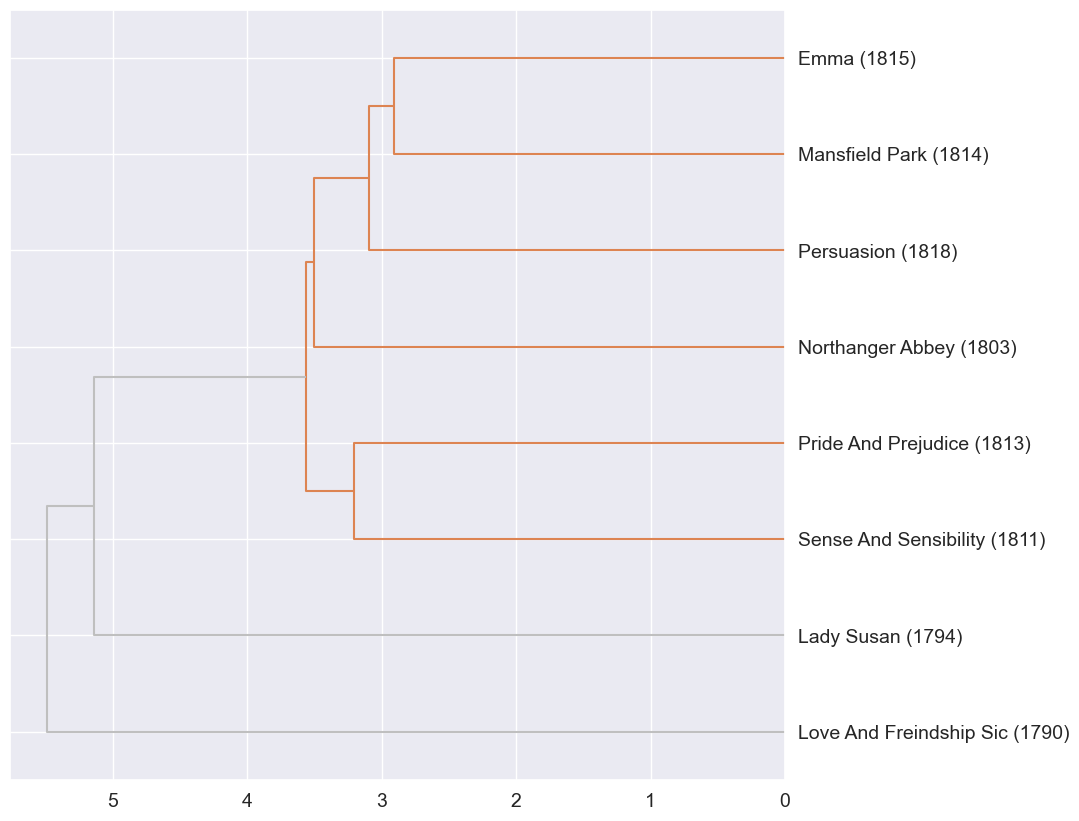

In [89]:
# 1: cityblock, none, weighted

hac(PAIRS.cityblock, linkage_method='weighted', color_thresh = 4)

<Figure size 640x480 with 0 Axes>

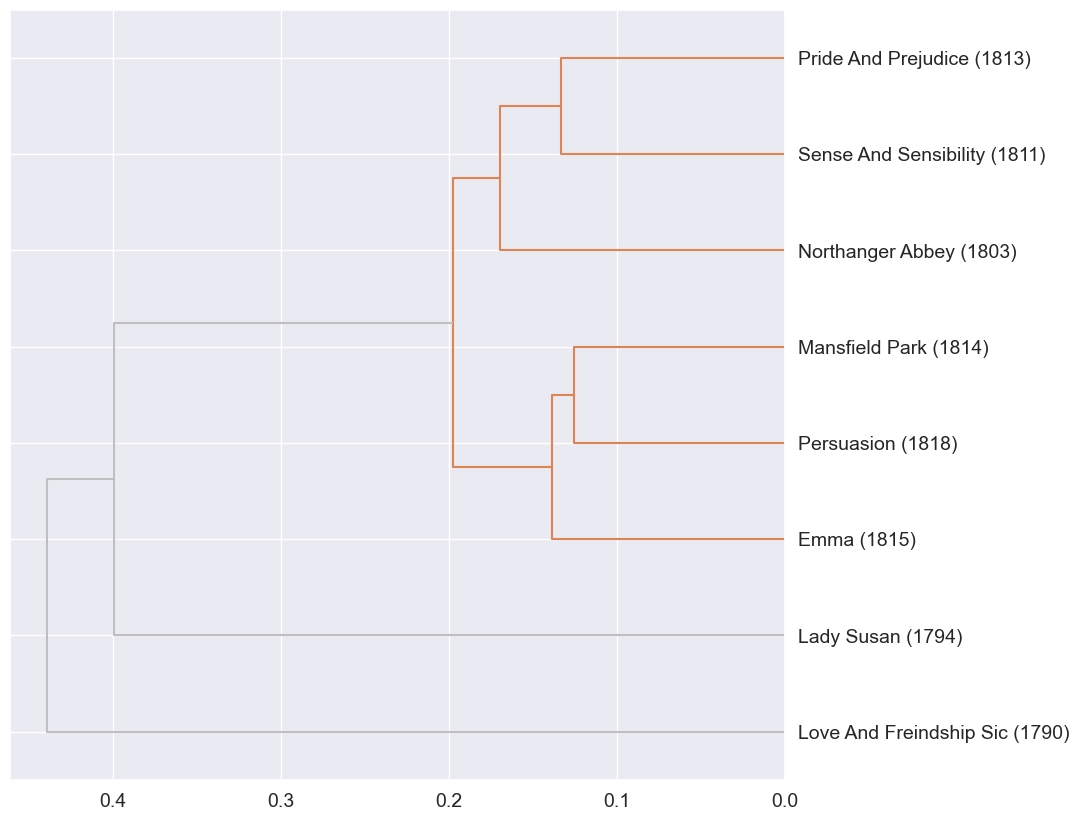

In [91]:
# 2: cosine, none, ward
hac(PAIRS.cosine, linkage_method='ward', color_thresh = 0.2)

<Figure size 640x480 with 0 Axes>

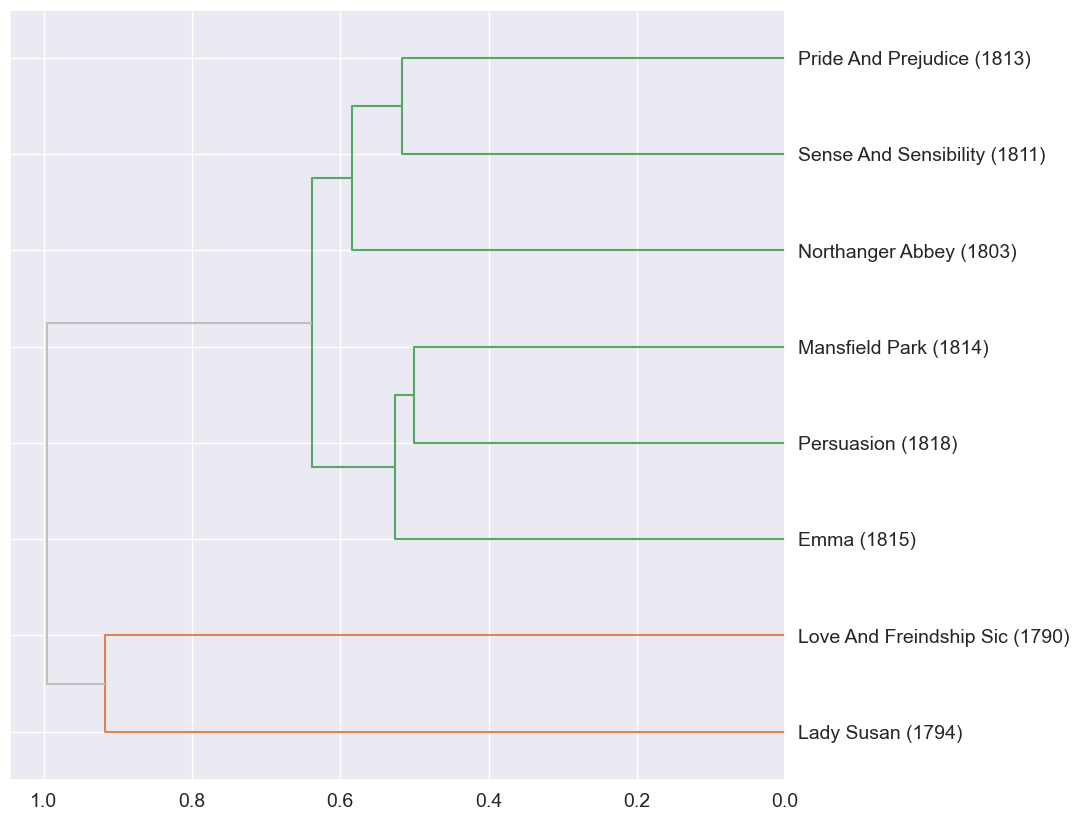

In [94]:
# 3: euclidean, L2, ward
hac(PAIRS.euclidean, linkage_method='ward', color_thresh = 0.95)

<Figure size 640x480 with 0 Axes>

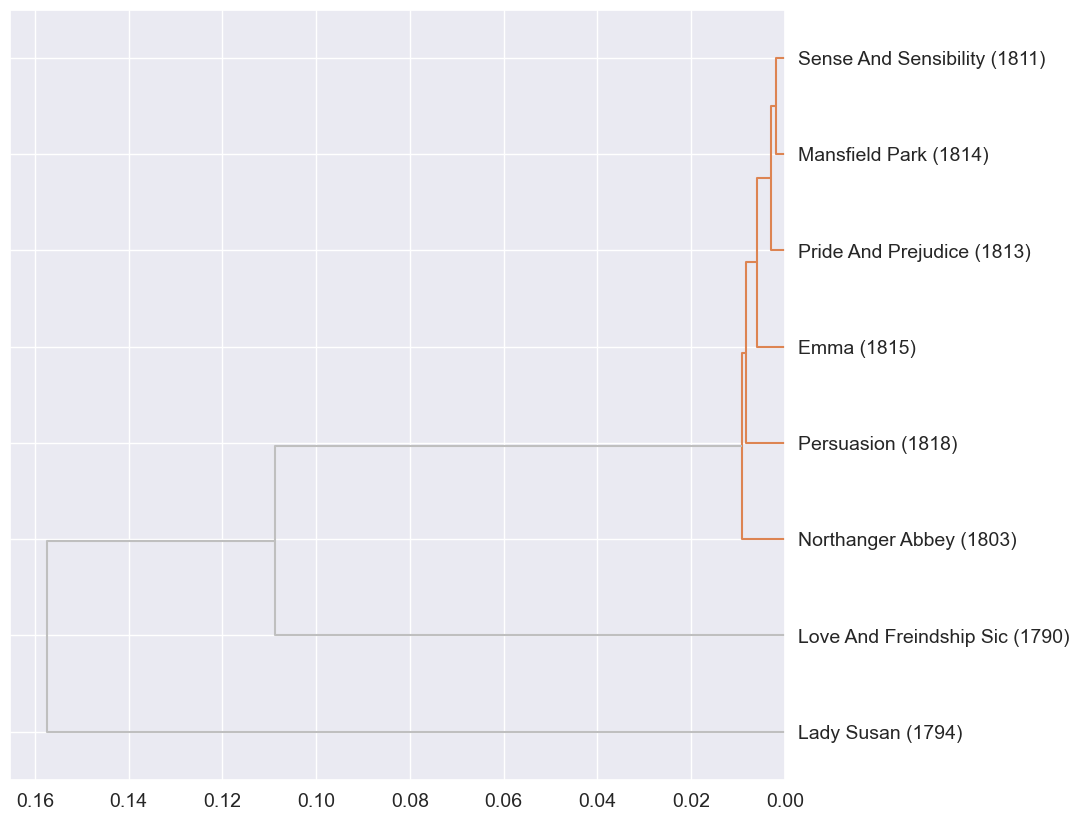

In [96]:
# 4: Jaccard, L0, weighted

hac(PAIRS.jaccard, linkage_method='weighted', color_thresh = 0.02)

<Figure size 640x480 with 0 Axes>

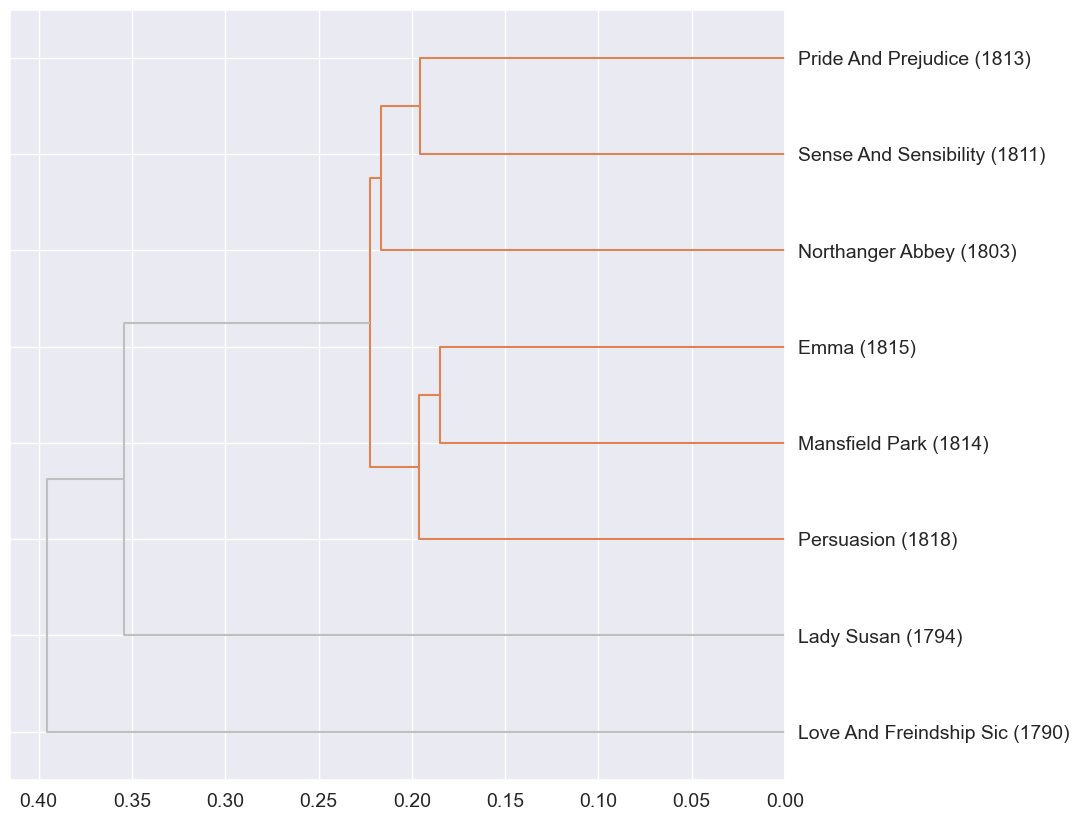

In [98]:
# 5: JensenShannon, L1, weighted

hac(PAIRS.js, linkage_method='weighted', color_thresh = 0.25)

Just a note that colors are fully based off of vibes - thought they would be fun to include and they were already baked into the function

### The Questions

#### Question 1: 

In [101]:
# filter by nouns
allowed_pos_q1 = ['NN', 'NNS']
allowed_terms_q1 = VOCAB[VOCAB['max_pos'].isin(allowed_pos_q1)]
DFIDF[DFIDF.index.isin(allowed_terms_q1.index)].sort_values(ascending=False).head(10)

term_str
respect      177.266344
fortune      177.261968
marriage     177.261968
ladies       177.258990
question     177.258990
farther      177.240001
behaviour    177.240001
advantage    177.217644
voice        177.209470
girl         177.209470
dtype: float64

#### Question 2:

In [104]:
TFIDF_book.mean(axis=1).sort_values(ascending=False)

book_id
158     0.008163
1342    0.008039
161     0.007963
141     0.007331
121     0.007267
105     0.007227
946     0.006310
1212    0.006030
dtype: float64

In [106]:
LIB.loc[158, 'label']

'Emma (1815)'

Austen's most "significant" book is *Emma*.

#### Question 3:

Looking at my dendrograms above, I would say that the Jaccard distance metric (L0 norm, weighted linkage) shows the greatest distinciton between Austen's juvenalia and the rest of her works. While the juvenalia does not form its own "cluster", as in the euclidean dendrogram, the gap is visually much wider between the juvenalia and the rest of the work in this case.

<Figure size 640x480 with 0 Axes>

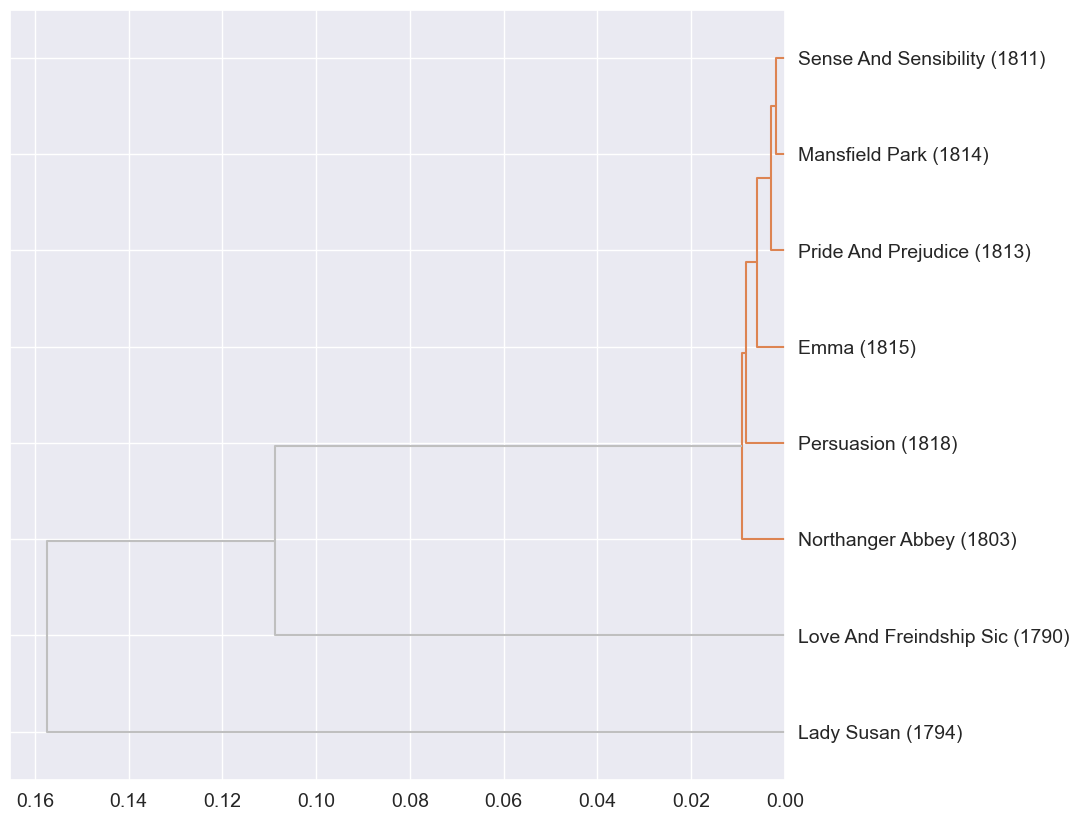

In [107]:
# just to showcase it
hac(PAIRS.jaccard, linkage_method='weighted', color_thresh = 0.02)

#### Question 4:

Not explicitly, (top to bottom or bottom to top as laid out by the dendrogram), no. But I think that Jensen-Shannon distance with L1 normalization and weighted linkage does showcase a perfectly chronological order (see below).

<Figure size 640x480 with 0 Axes>

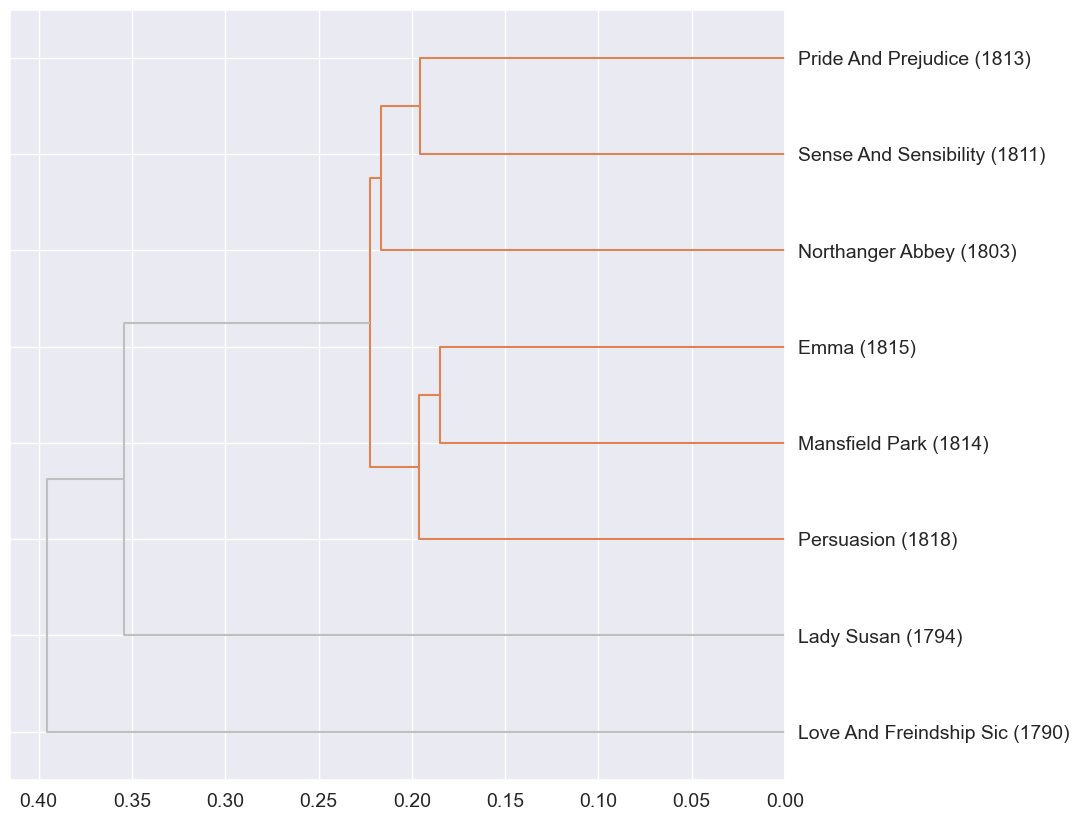

In [111]:
hac(PAIRS.js, linkage_method='weighted')

*Love and Friendship and other works* is the furthest removed from the rest of Austen's corpus, followed by *Lady Susan*, to make up the juvenalia. From there the work is further sorted into an earlier and a later period, with *Northanger Abbey* being the most distant from the other works (see the height of that particular linkage), but closer to *Sense* and *Pride* than the three post-1813 works. Of the later period, *Mansfield Park* and *Emma* are closer than *Persuasion*, which also makes chronological sense. So without changing anything that conveys actual information in the graph, we could reorder it to be in chronological order. 

#### Question 5:

It seems that Jaccard distance with L0 normalization and weighted linkage corroborates the thesis that *Northanger Abbey* "most" resembles her juvenalia (and several others also show the greatest distance between it and the later novels). However, the question seems to be asking two different things - to answer the second part, none of the distance metrics appear to place it *closer* to Austen's juvenalia than her adult works. The linkage between her adult works and *Northanger Abbey* is stronger across the board.

In [113]:


D1 = np.array([0, 5, 9, 3, 0, 5, 9, 0, 0, 0, 9, 7, 0])

D2 = np.array([5, 5, 0, 3, 0, 5, 2, 0, 1, 0, 9, 5, 0])

np.sqrt(np.sum((D1 - D2)**2))

12.649110640673518